In [21]:
import sys
import pprint
import os
import time
import numpy as np
import h5py
import yaml, json
from PIL import Image
import IPython
%pylab inline
plt.rcParams['image.cmap'] = 'gray'

# get magic root folder
config_path="/work/ds_config.yaml"
with open(config_path) as f:
    configs = yaml.safe_load(f)
sys.path.append(configs['PROJECT_ROOT'])

# project-specific
from data_iters import iam_hdf5_iterator
from viz_tools import VizUtils, array_to_png
data_root = configs['DATA_ROOT']

# deep learning imports
import keras
from keras.utils.np_utils import to_categorical
import theano
theano.config.exception_verbosity='high'
theano.config.optimizer='fast_compile'

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten, AutoEncoder
from keras.layers.convolutional import MaxPooling2D, Convolution2D, Convolution1D

from keras.optimizers import SGD, Adam

from seya.attention import SpatialTransformer

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


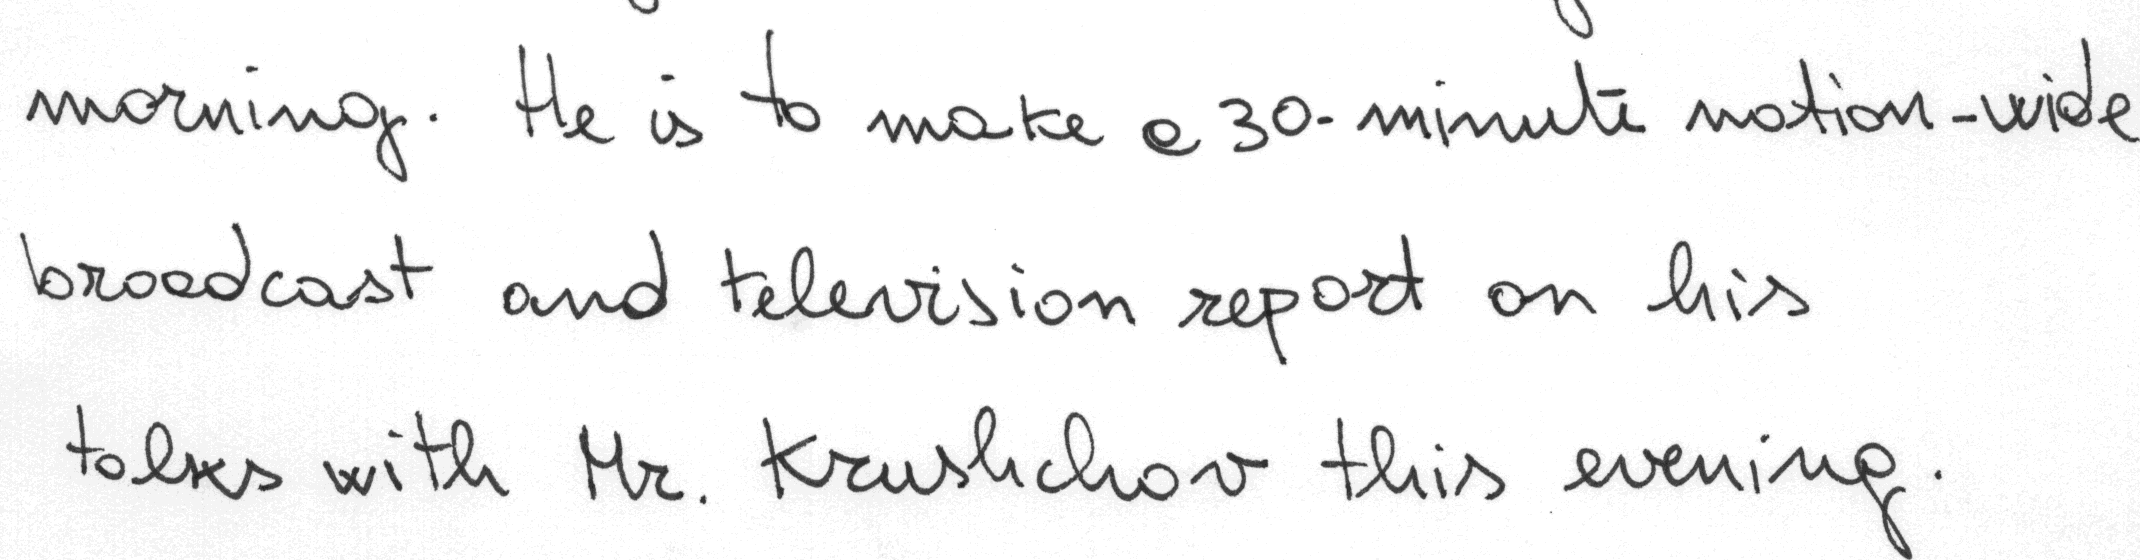

In [12]:
form_id = 'a04-010'
def iam_get_hw(form_id, data_root):
    hw_l, hw_t, hw_r, hw_b = VizUtils.iam_get_text_block(form_id, data_root)
    forms_path = os.path.join(data_root, "iam-processed/forms/forms.hdf5")
    with h5py.File(forms_path, "r") as f:
        img_array = f[form_id].value[hw_t:hw_b,hw_l:hw_r]
    return img_array
img_array = iam_get_hw(form_id, data_root)
# take bottom 40%
img_sample = array_to_png.get_png_from_array(img_array[int(0.6*img_array.shape[0]):])
img_png = array_to_png.get_png_from_array(img_array)
#IPython.display.Image(img_png,format='png')
IPython.display.Image(img_sample,format='png')
    

In [56]:
class IamHandwritingIterator:
    def __init__(self, data_root, h_start=0., h_end=1.,fixed_width=None):
        self.data_root = data_root
        self.limits = h_start, h_end
        self.forms_list = [ f[:-4] for f in os.listdir(os.path.join(data_root, "forms")) if f[-4:]==".png"]
        self.fixed_width=fixed_width
    
    def __iter__(self):
        return self
    
    @staticmethod
    def get_author(form_id, data_root):
        forms_data = os.path.join(data_root, "forms.txt")
        with open(forms_data) as f:
            for form_line in f:
                fields = form_line.split(' ')
                try:
                    b_form_id = fields[0]
                    author_id = fields[1]
                except IndexError:
                    continue
                if b_form_id == form_id:
                    return author_id
    
    def next(self):
        try:
            next_form = self.forms_list.pop()
        except IndexError:
            raise StopIteration
            
        # open img
        img = iam_get_hw(next_form, self.data_root)
        top = int(img.shape[0] * self.limits[0])
        bottom = int(img.shape[0] * self.limits[1])
        return self.get_author(next_form, self.data_root), img[top:bottom,:]


foo = IamHandwritingIterator(data_root, 0., 0.2)
for i, (author, form) in enumerate(foo):
    IPython.display.clear_output(wait=True)
    #form_png = array_to_png.get_png_from_array(form)
    print "Author:", author
    print form.shape
    print "{0} printed".format(i)
    #IPython.display.display_png(form_png,raw=True)
    #time.sleep(1)
    
    

Author: 495
(159, 1914)
1538 printed


In [13]:
# Localization Net
batch_size = 256
epoch_size = 1000
nb_authors = 100

def locnet(input_shape = (1,128,128)):
    b = np.zeros((2, 3), dtype='float32')
    b[0, 0] = 1
    b[1, 1] = 1
    W = np.zeros((50, 6), dtype='float32')
    weights = [W, b.flatten()]
    # from seya's STN demo notebook:
    locnet = Sequential()
    locnet.add(MaxPooling2D(pool_size=(4,4), input_shape=input_shape))
    locnet.add(Convolution2D(20, 4, 4))
    locnet.add(MaxPooling2D(pool_size=(2,2)))
    locnet.add(Convolution2D(20, 4, 4))

    locnet.add(Flatten(input_shape=input_shape))
    locnet.add(Dense(50))
    locnet.add(Activation('relu'))
    locnet.add(Dense(6, weights=weights))
    
    return locnet

def stn_model(locnet, input_shape=(1,128,128), nb_outputs=100, downsample_factor=2):
    model = Sequential()
    model.add(SpatialTransformer(locnet, input_shape=input_shape, downsample_factor=downsample_factor))
    model.add(Convolution2D(32, 4, 4, border_mode='valid'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Convolution2D(32, 3, 3))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(8, 8)))

    model.add(Flatten())
    model.add(Dense(256))
    model.add(Activation('relu'))

    model.add(Dense(nb_outputs))
    model.add(Activation('softmax'))

    adam = Adam(lr=0.0001)

    model.compile(loss='categorical_crossentropy', optimizer=adam)
    
    return model

[59, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 3, 2, 1, 3, 3, 2, 3, 1, 1, 1, 1, 1, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 3, 3, 4, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 6, 1, 3, 3, 3, 3, 2, 3, 3, 3, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 7, 2, 1, 2, 1, 5, 4, 5, 5, 3, 5, 4, 5, 4, 4, 5, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 10, 10, 10, 10, 10, 9, 1, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 5, 5, 2, 1, 2, 2, 2, 2, 3, 1, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 4, 2, 2, 1, 2, 2, 4, 1, 1, 5, 5, 5, 5, 5, 5, 5, 7, 2, 2, 3, 3, 2, 2, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 4, 2, 4, 3, 3, 1, 1, 4, 5, 5, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 5, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 4, 5, 5, 5, 1, 4, 5, 5, 4, 2, 3, 3, 3, 3, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 4, 1, 8, 9, 9, 8, 9, 

IndexError: pop from empty list